In [1]:
import os
import gdown
import torch
import numpy as np
import seaborn as sns
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn import metrics
from scipy.special import softmax

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import torch.nn.functional as F

LABEL_MAP = {0 : "negative", 1 : "positive"}
NONE = 4 * [None]
RND_SEED=2020

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def plot_confusion_matrix(y_true, y_predicted):
    cm = metrics.confusion_matrix(y_true, y_predicted)
    print("Plotting the Confusion Matrix")

    labels = sorted(set(y_true) | set(y_predicted))  # Extract labels dynamically from y_true and y_predicted
    labels_str = [str(label) for label in labels]  # Convert labels to strings if they are not already

    df_cm = pd.DataFrame(cm, index=labels_str, columns=labels_str)
    fig = plt.figure(figsize=(14, 12))
    res = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.close()

In [3]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
RND_SEED = 42


In [ ]:
# Load the data
file_path = '../../archive/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(file_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [7]:
df['target_binary'] = df['target'].apply(lambda x: 1 if x == 4 else 0)


In [8]:
# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RND_SEED)

# Verify the split
print(f"Number of training samples: {len(df_train)}")
print(f"Number of testing samples: {len(df_test)}")

Number of training samples: 1280000
Number of testing samples: 320000


In [12]:
journals = df_train['text'].values
labels = df_train['target_binary'].values

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)
tokenizer.vocab_size

30522

In [16]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize(journals[0]))

journals_with_special_tokens = []

for journal in journals:
    journals_with_special_tokens.append("[CLS] " + journal + " [SEP]")

In [18]:
tokenized_texts = []

for journal in journals_with_special_tokens:
    tokenized_texts.append(tokenizer.tokenize(journal))

input_ids = []

for i in tokenized_texts:
    input_id = tokenizer.convert_tokens_to_ids(i)
    input_ids.append(input_id)

In [19]:
input_ids = pad_sequences(input_ids,
                          maxlen=128,
                          dtype="long",
                          truncating="post",
                          padding="post")

In [20]:
attention_masks = []

for i in input_ids:
    mask=[float(j>0) for j in i]
    attention_masks.append(mask)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size = 0.2, random_state = RND_SEED)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size = 0.2, random_state = RND_SEED)

### convert data to tensors and create DataLoaders

In [25]:
#@title Run this cell to convert data to tensors and create DataLoaders
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); # Samples data randonly for training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); # Samples data sequentially
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### initialize your BertForSequenceClassification model

In [26]:
#@title Run this cell to initialize your BertForSequenceClassification model
#Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT small model, with an uncased vocab.
    num_labels = 2,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
);

# Given that this a huge neural network, we need to explicity specify
# in pytorch to run this model on the GPU.
model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

'NVIDIA GeForce RTX 3080'

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, ### YOUR CODE HERE
                  eps = 1e-8
                )
epochs = 2

### train your model!

In [28]:
#@title Run this cell to train your model!

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# We'll store training and validation loss,
# validation accuracy, and timings.
training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    # Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    # Reset the total loss for  epoch.
    total_train_loss = 0
    # Put the model into training mode.
    model.train()
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 10000 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        # STEP 1 & 2: Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # STEP 3
        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # STEP 4
        # Perform a forward pass (evaluate the model on this training batch).
        # It returns the loss (because we provided labels) and
        # the "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # STEP 5
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # STEP 6
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # Validation
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("Evaluating on Validation Set")
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        #Step 1 and Step 2
        # Unpack this validation batch from our dataloader.

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)



    print("Validation Loss: {0:.2f}".format(avg_val_loss))


    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy

        }
    )

print("Training complete!")

Epoch 1 / 2 ========
Training the model
  Batch 10,000  of  32,000. 
  Batch 20,000  of  32,000. 
  Batch 30,000  of  32,000. 
  Average training loss: 0.33
Evaluating on Validation Set
Validation Accuracy: 0.87
Validation Loss: 0.30
Epoch 2 / 2 ========
Training the model
  Batch 10,000  of  32,000. 
  Batch 20,000  of  32,000. 
  Batch 30,000  of  32,000. 
  Average training loss: 0.26
Evaluating on Validation Set
Validation Accuracy: 0.88
Validation Loss: 0.31
Training complete!


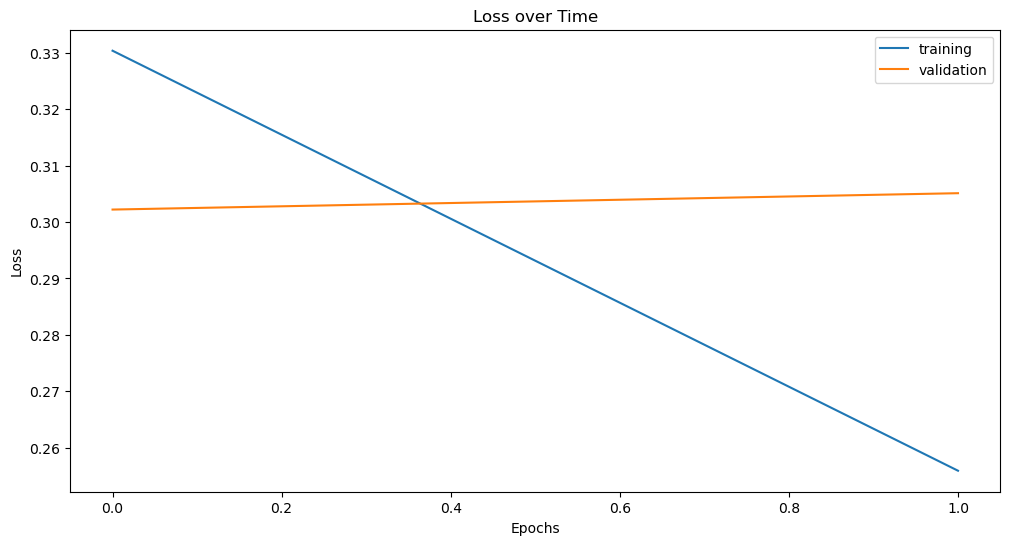

In [29]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label = "training")
plt.plot(validation_loss, label = "validation")

plt.legend()
plt.show()

In [38]:
# Tracking variables for validation
all_val_logits = []
all_val_labels = []

# Evaluate data for one epoch
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

    total_eval_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Collect logits and labels
    all_val_logits.extend(logits)
    all_val_labels.extend(label_ids)

    # Print shapes for debugging
    #print(f"logits shape: {logits.shape}")
    #print(f"labels shape: {label_ids.shape}")
print('done')

done


All logits shape: (256000, 2)
All labels shape: (256000,)
Validation Accuracy: 0.88
Validation Confusion Matrix:
 [[113248  15350]
 [ 16527 110875]]
Validation AUC: 0.9473


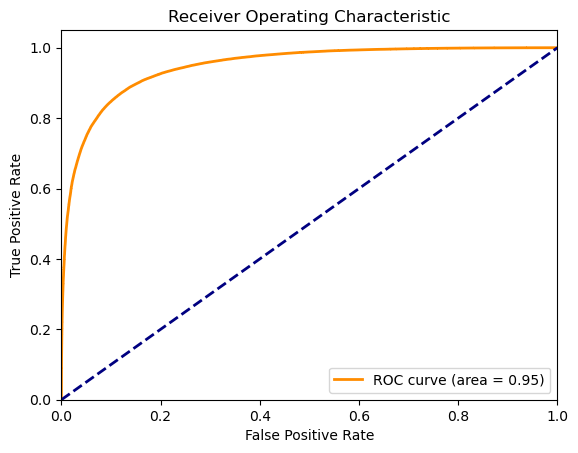

In [42]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Function to calculate accuracy
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Ensure logits and labels are numpy arrays
all_val_logits = np.array(all_val_logits)
all_val_labels = np.array(all_val_labels)

# Check shapes after collecting all logits and labels
print(f"All logits shape: {all_val_logits.shape}")
print(f"All labels shape: {all_val_labels.shape}")

# Calculate validation accuracy
val_accuracy = calculate_accuracy(all_val_logits, all_val_labels)
print("Validation Accuracy: {:.2f}".format(val_accuracy))

# Confusion Matrix
val_conf_matrix = confusion_matrix(all_val_labels, np.argmax(all_val_logits, axis=1))
print("Validation Confusion Matrix:\n", val_conf_matrix)

# For Binary Classification - Use the probabilities of the positive class
if all_val_logits.shape[1] == 2:
    probabilities = all_val_logits[:, 1]  # Probabilities for the positive class
else:
    probabilities = np.max(all_val_logits, axis=1)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(all_val_labels, probabilities)
roc_auc = auc(fpr, tpr)
print("Validation AUC: {:.4f}".format(roc_auc))

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### process and prepare our test data!

In [30]:
test_sentences = df_test['text'].values
test_labels = df_test['target_binary'].values

In [33]:
#@title Run this cell to process and prepare our test data!
test_input_ids, test_attention_masks = [], []

# Add Special Tokens
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

# Tokenize sentences
tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

# Encode Tokens to Word IDs
test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

# Pad the inputs
test_input_ids = pad_sequences(test_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")

# Create Attention Masks
for sequence in test_input_ids:
    mask = [float(i>0) for i in sequence]
    test_attention_masks.append(mask)

In [34]:
#@title Run this cell to convert data to tensors and create DataLoaders
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Evaluate Test Set Accuracy!

In [51]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Final tracking variables
y_logits, y_true, y_preds = [], [], []

# Gather logit predictions
for chunk in predictions:
    for logits in chunk:
        y_logits.append(logits)

# Gather true labels
for chunk in true_labels:
    for label in chunk:
        y_true.append(label)

# Gather real predictions
for logits in y_logits:
    y_preds.append(np.argmax(logits))

# Calculate test accuracy
test_accuracy = accuracy_score(y_true, y_preds)
print('Test Accuracy: {:.2%}'.format(test_accuracy))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:\n", conf_matrix)



Predicting labels for 320,000 test sentences...
Test Accuracy: 87.51%
Confusion Matrix:
 [[141453  18041]
 [ 21927 138579]]


Test AUC: 0.95


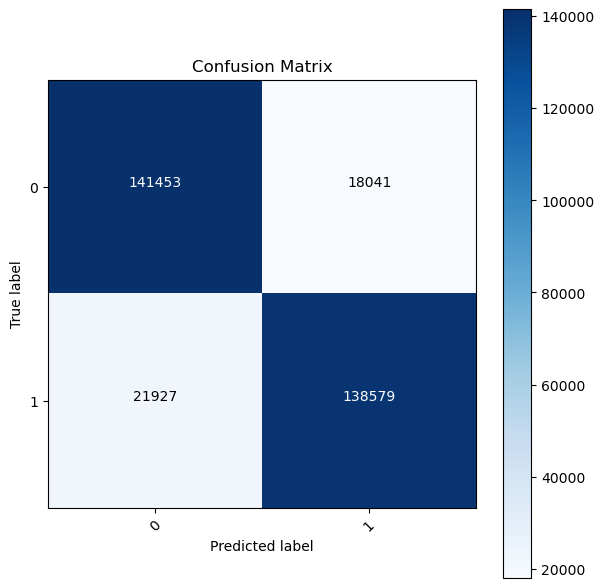

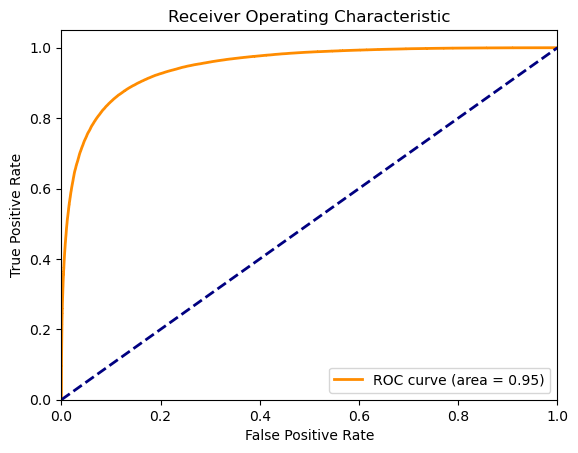

In [52]:
import itertools

# Plotting the confusion matrix
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix, labels=[0, 1])

# ROC Curve and AUC for binary classification
# We need the probabilities for the positive class
y_probs = np.array([logit[1] for logit in y_logits])  # Probabilities for the positive class

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
print('Test AUC: {:.2f}'.format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Save Model

In [47]:
# Save the model
# Save the model and tokenizer
save_directory = "model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)  # Only if you used a tokenizer

('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\vocab.txt',
 'model\\added_tokens.json')

In [17]:

# Load the model and tokenizer from the directory
model_load_directory = "model"
model = BertForSequenceClassification.from_pretrained(model_load_directory)
tokenizer = BertTokenizer.from_pretrained(model_load_directory)  # Only if you used a tokenizer

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

print("Model and tokenizer loaded from disk and moved to device:", device)

print("Model and tokenizer loaded from disk")

Model and tokenizer loaded from disk and moved to device: cuda
Model and tokenizer loaded from disk


### Predict 

In [18]:
journal_path = 'data/csv/journal_data.csv'
j_df = pd.read_csv(journal_path, encoding =DATASET_ENCODING)

In [19]:
j_df

,user_id,journal,before_after,id
0,1,Today was a pretty regular day at school. Duri...,0,1
1,1,School was super stressful today! I had a math...,0,2
2,1,Saturdays are my favorite! No school and all p...,0,3
3,1,Tuesdays are always meh. School is neither her...,0,4
4,1,School was exhausting today. We had back-to-ba...,0,5
...,...,...,...,...
3006,300,"Today was a bit better. School was still hard,...",1,3007
3007,300,Feeling a bit brighter today. School was more ...,1,3008
3008,300,Had a decent day today. School felt less overw...,1,3009
3009,300,Today was pretty good. School wasnï¿½t overwhe...,1,3010


In [20]:
journals_test = j_df['journal'].values

In [21]:
len(journals_test)

3011

In [22]:
journals_with_special_tokens = ["[CLS] " + journal + " [SEP]" for journal in journals_test]
tokenized_texts = [tokenizer.tokenize(journal) for journal in journals_with_special_tokens]

# Convert tokens to input IDs
input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]

# Pad sequences
input_ids = pad_sequences(input_ids, maxlen=128, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = [[float(j > 0) for j in i] for i in input_ids]


In [23]:
len(input_ids)

3011

In [24]:
# Convert to tensors
predict_inputs = torch.tensor(np.array(input_ids))
predict_masks = torch.tensor(np.array(attention_masks))

In [25]:
batch_size = 32
predict_data = TensorDataset(predict_inputs, predict_masks)
predict_sampler = SequentialSampler(predict_data)
predict_dataloader = DataLoader(predict_data, sampler=predict_sampler, batch_size=batch_size)

In [26]:
len(journals_with_special_tokens)

3011

In [32]:
model.eval()

all_logits = []

for batch in predict_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
    
    logits = logits.detach().cpu().numpy()
    all_logits.append(logits)

# Concatenate the logits from all batches
all_logits = np.concatenate(all_logits, axis=0)

# Convert logits to probabilities
probabilities = F.softmax(torch.tensor(all_logits), dim=1).numpy()

# Get predicted labels based on probabilities
predicted_labels = np.argmax(probabilities, axis=1)

# Get positive class probabilities (assuming binary classification with positive class at index 1)
positive_probabilities = probabilities[:, 1]

# Add predicted labels and positive probabilities to DataFrame
j_df['predicted_label'] = predicted_labels
j_df['positive_probability'] = positive_probabilities

In [33]:
len(probabilities)

3011

In [34]:
j_df.to_csv('data/csv/predicted_sentiments.csv', index=False)